Тебе предстоит разработать модель машинного обучения для предсказания вероятности оттока клиентов в телекоммуникационной компании. У тебя есть набор данных, который содержит различные признаки о клиентах, такие как возраст, пол, тип подключения, длительность пользования услугами и т.д.

Твоя задача состоит в следующем:

1. Загрузить данные и провести предварительный анализ данных.

2. Подготовить данные для обучения модели. Это может включать удаление ненужных признаков, заполнение пропущенных значений и нормализацию данных.

3. Разделить данные на обучающую и тестовую выборки.

4. Выбрать модель машинного обучения, которую ты хочешь использовать для предсказания оттока клиентов. Например, можно использовать модель классификации, такую как логистическая регрессия или случайный лес.

5. Обучить модель на обучающей выборке и оценить ее производительность на тестовой выборке.

6. Провести анализ результатов и оценить важность различных признаков для предсказания оттока клиентов.

7. При необходимости, провести дополнительные эксперименты, чтобы улучшить производительность модели. Это может включать изменение параметров модели, добавление новых признаков или использование другой модели машинного обучения.

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, classification_report
import io
from pathlib import Path
import math


In [224]:
# Сгруппируем основную информацию о датасете и выгрузим в excel.
# import io
def unload_dataset_info(df:pd.DataFrame, dataset_file_name:str)->pd.DataFrame:
    info_filename = f'./{Path(dataset_file_name).stem}_info.xlsx'
    buf = io.StringIO()
    df.info(buf=buf)
    s = buf.getvalue()
    columns = s.splitlines()[3].split()
    lines =   [line.split() for line in s.splitlines()[5:-2]]
    lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
    df_info = pd.merge(
        pd.DataFrame(lines, columns=columns[1:])
        , df.nunique().to_frame(name='Nu'), 
        left_on='Column', 
        right_index=True)# .set_index(['#']).reset_index()
    df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
    df_info = pd.merge(df_info, df_vc, how='left', on='Column')
    df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
    df_info = df_info[['Column', 'Non-Null']].copy()\
        .join(pd.DataFrame(df.isna().sum()).rename(columns={0: 'Null_cnt'}), how='left', on='Column')\
        .join(pd.DataFrame(df.isna().sum() / df.shape[0]).round(3).rename(columns={0: 'Null_percent'}), how='left', on='Column')\
        .join(df_info.set_index('Column').drop(columns=['Non-Null', 'Count'] ), how='left', on='Column')
    if not Path(info_filename).exists():
        df_info.to_excel(info_filename, index=False)
    return df_info

In [225]:
def rm_item_from_list(item:any, lst:list)->list:
    result = lst[:]
    if isinstance(item, list):
        item_list = item[:]
    else:
        item_list = []
        item_list.append(item)
    for el in item_list:
        try:
            result.remove(el)
        except ValueError:
            next
    return result

In [226]:
dataset_filename = "./Telco-Customer-Churn.csv" 
df = pd.read_csv(dataset_filename)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [227]:
display(unload_dataset_info(df, dataset_filename))

# Пропусков нет.
# Большинство признаков категориальные.

,Column,Non-Null,Null_cnt,Null_percent,Dtype,Nu,vc,count,mean,std,min,25%,50%,75%,max
0,customerID,7032,0,0.0,object,7032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gender,7032,0,0.0,object,2,"[(Female, 3483), (Male, 3549)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SeniorCitizen,7032,0,0.0,int64,2,"[(0, 5890), (1, 1142)]",7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
3,Partner,7032,0,0.0,object,2,"[(No, 3639), (Yes, 3393)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dependents,7032,0,0.0,object,2,"[(No, 4933), (Yes, 2099)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,tenure,7032,0,0.0,int64,72,NaN,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
6,PhoneService,7032,0,0.0,object,2,"[(No, 680), (Yes, 6352)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MultipleLines,7032,0,0.0,object,3,"[(No, 3385), (No phone service, 680), (Yes, 29...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,InternetService,7032,0,0.0,object,3,"[(DSL, 2416), (Fiber optic, 3096), (No, 1520)]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,OnlineSecurity,7032,0,0.0,object,3,"[(No, 3497), (No internet service, 1520), (Yes...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
# df.query('StreamingMovies == "No internet service"')

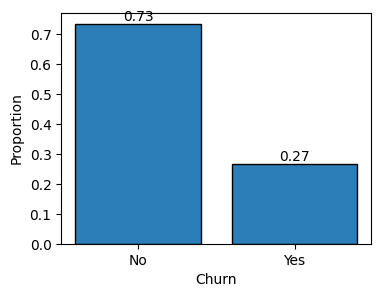

In [268]:
# Посмотрим распределение целевой переменной 
target_feature = 'Churn'
plt.figure(figsize=(4,3))
ax = sns.histplot(data=df[target_feature], stat='proportion', shrink=.8, alpha = 0.95)
ax.bar_label(ax.containers[0], fmt='%.2f');

# Наблюдаем, что классы целевой переменной не сбалансированные.
# Соотношение классов составляет  73/27. Меньше представлен класс, обозначающий отток 
# Дисбаланс классов не является критичным.


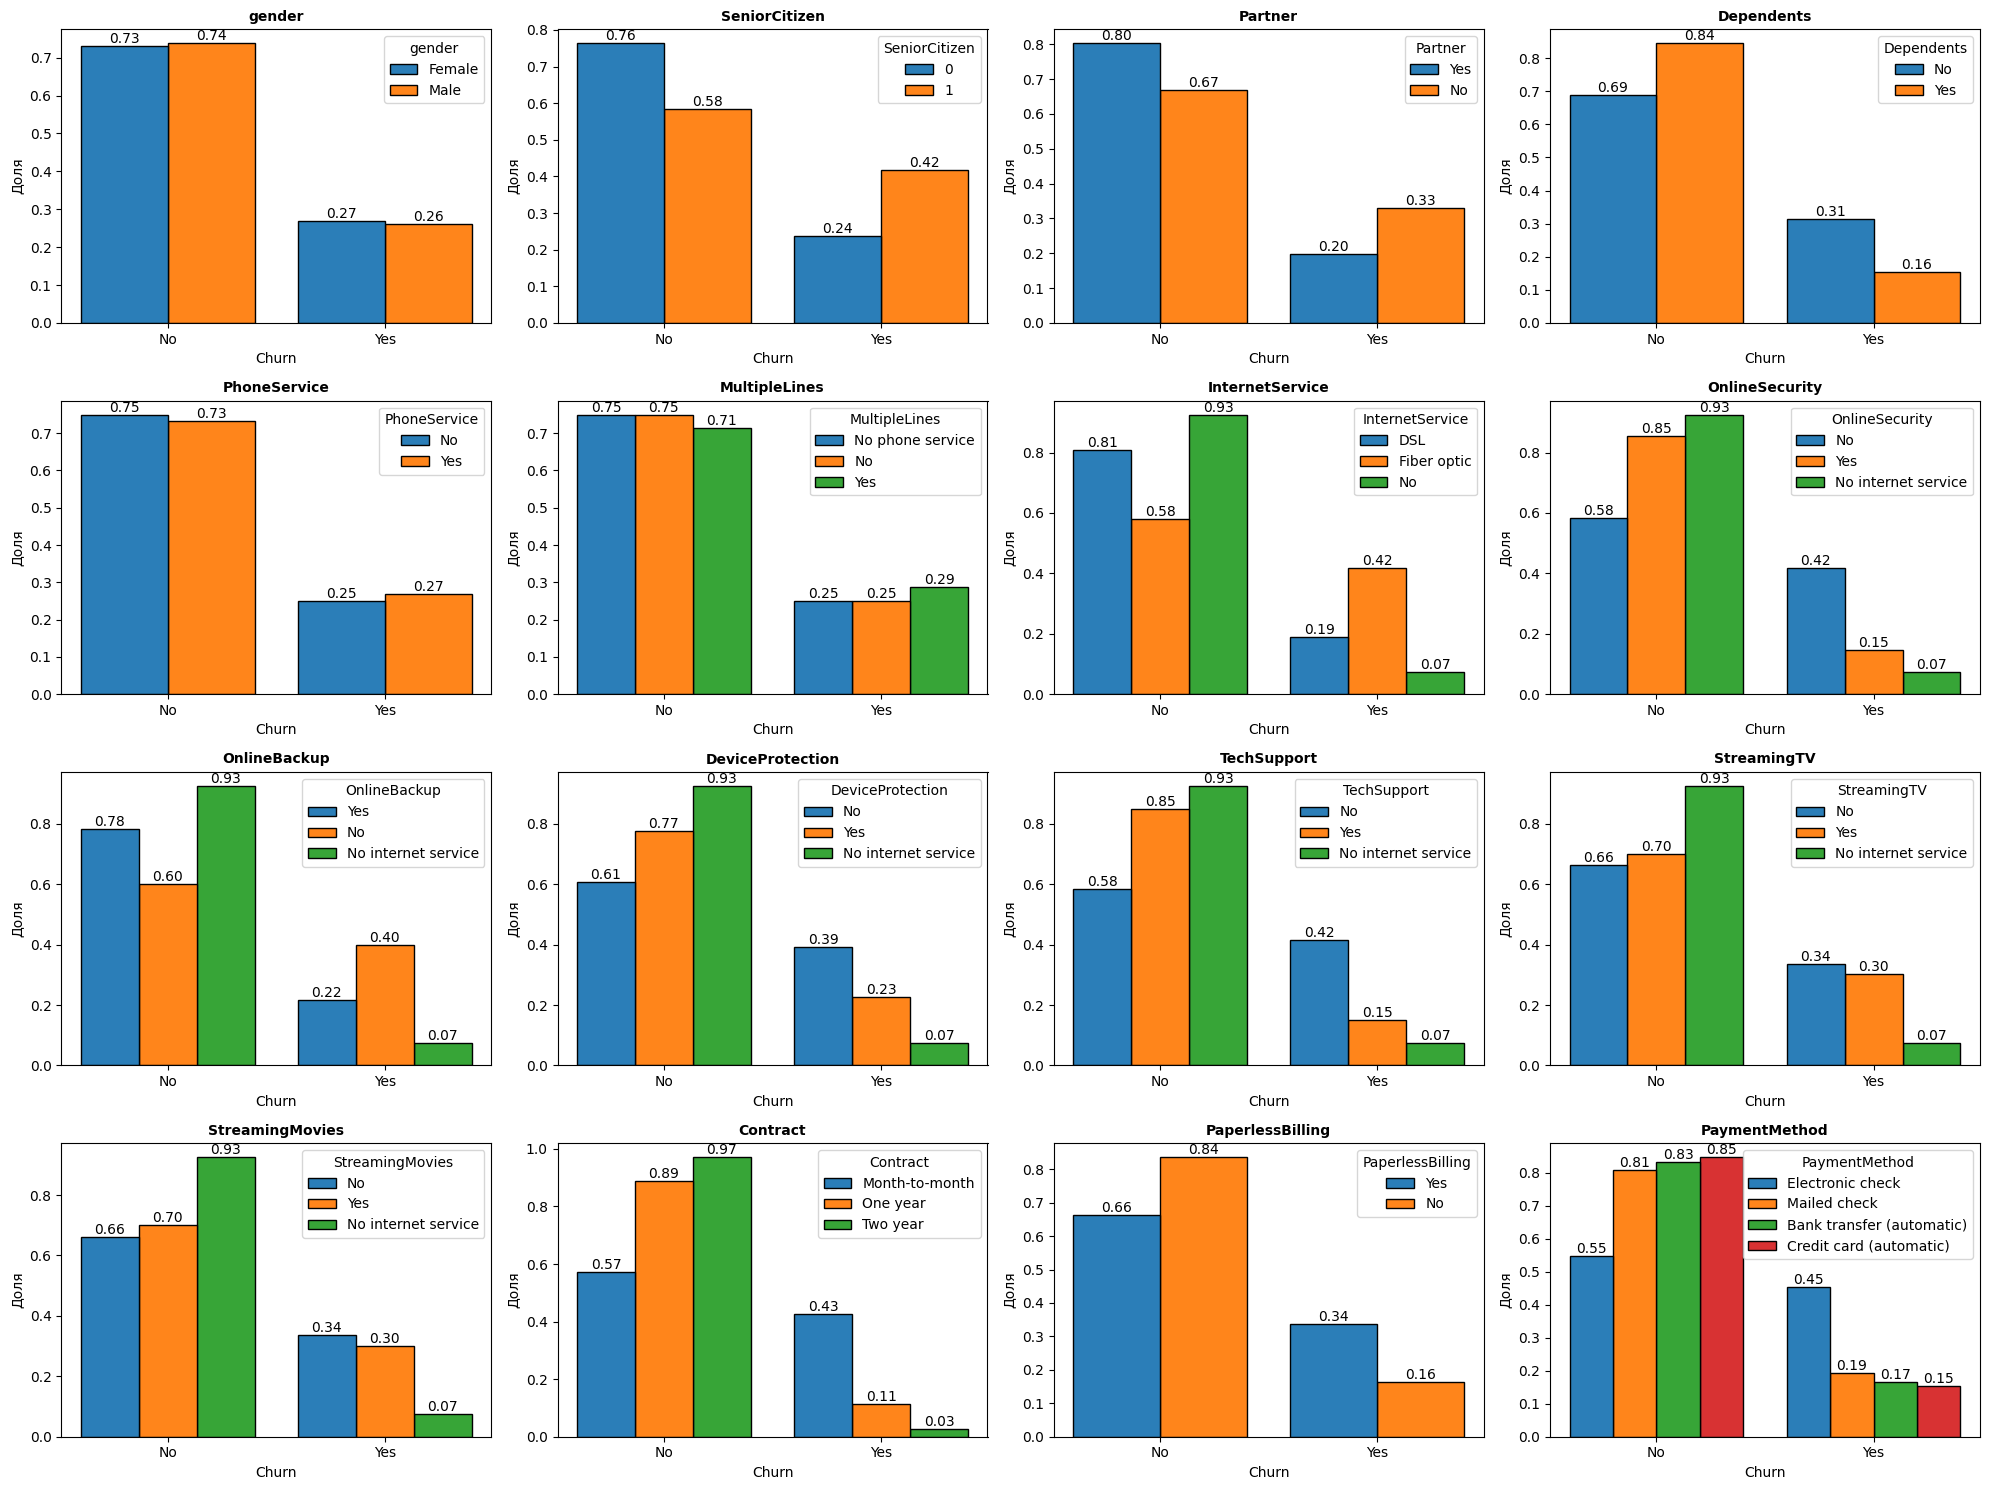

In [ ]:
# Отобразим зависимость категориальных переменных от целевой переменной

cat_features = ['gender',  'SeniorCitizen',  'Partner',  'Dependents',  'PhoneService',  'MultipleLines',  'InternetService',  'OnlineSecurity',  'OnlineBackup',
 'DeviceProtection',  'TechSupport',  'StreamingTV',  'StreamingMovies',  'Contract',  'PaperlessBilling', 'PaymentMethod']
pic_from_line = 4
pic_from_col = math.ceil(len(cat_features) / pic_from_line)

fig, axes = plt.subplots(pic_from_col, pic_from_line, figsize = (20,15))
# Расстояние между графиками
# plt.subplots_adjust(hspace=0.5)

columns = df[cat_features].columns

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // pic_from_line, i % pic_from_line]
    # sns.kdeplot(data = df[cat_features], x = column, fill = True, alpha = 0.8, hue = df['Churn'], ax = ax , common_norm=False)
    sns.histplot(data=df, x=target_feature, hue=column, multiple='dodge', stat='proportion', shrink=.8, alpha = 0.95, ax = ax, common_norm=False)
    l = list(ax.containers)    
    for i in range(df[column].nunique()):
        labels_list = [f'{j.get_height():.2f}' for j in l[i]]
        ax.bar_label(l[i], labels=labels_list)    
    ax.set_title(column, fontweight = 'bold', fontsize = 10)
    # ax.set_xlabel(column, fontsize = 10)
    ax.set_ylabel('Доля', fontsize = 10)

plt.tight_layout()
plt.show();

In [231]:
# Предположим, что наибольшей разделяющей способностью будут обладать признаки, где распределение отличается от распределения целевой переменной.
# 'SeniorCitizen',  'Partner',  'Dependents', 'InternetService',  'OnlineSecurity',  'OnlineBackup',
# 'DeviceProtection',  'TechSupport',  'StreamingTV', 'Contract',  'PaperlessBilling', 'PaymentMethod'

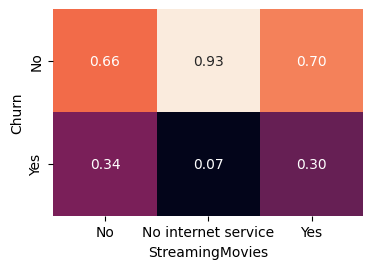

In [232]:
# Это пример построения таблиц сопряженности, по которым тоже можно определить зависимость одной категориальной переменной от другой
plt.figure(figsize = (4,4))
sns.heatmap(pd.crosstab(index=df[target_feature], columns=df['StreamingMovies'], normalize='columns' ), annot=True, fmt='.2f',square=True, cbar=False);

# plt.figure(figsize = (4,4))
# sns.heatmap(pd.crosstab(index=df['Churn'], columns=df['gender'], normalize='columns' ), annot=True, fmt='.3f',square=True, cbar=False);


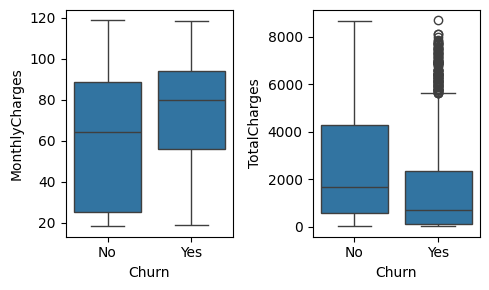

In [ ]:
num_features = ['MonthlyCharges', 'TotalCharges']
fig, axs = plt.subplots(1, 2, figsize=(5,3))
# fig.suptitle('Распределение целевой переменной')
sns.boxplot(ax=axs[0], x=df[target_feature], y=df[num_features[0]])
sns.boxplot(ax=axs[1], x=df[target_feature], y=df[num_features[1]])
plt.tight_layout()
plt.show();

# Наблюдаем, немного странную картину:
#  - клиенты, имеющие более высокие расходы, чаще попадают в отток.
#  - однако же, клиенты, имеющие более высокие общие расходы, реже попадают в отток.

2. Подготовить данные для обучения модели. Это может включать удаление ненужных признаков, заполнение пропущенных значений и нормализацию данных.

In [233]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
cat_features_for_encoded1 = ['gender',  'Partner',  'Dependents',  'PhoneService',  'InternetService',  'Contract',  'PaperlessBilling', 'PaymentMethod']
onehotencoder = OneHotEncoder(sparse_output=False, drop='first')
df_encoded = df.join(pd.DataFrame(onehotencoder.fit_transform(df[cat_features_for_encoded1]).astype(int), columns=onehotencoder.get_feature_names_out()))
cat_features_encoded = onehotencoder.get_feature_names_out()
# df_encoded[onehotencoder.get_feature_names_out()] = 
df_encoded[cat_features_encoded]

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,0,0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,1,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,0,1
3,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1,1,1,1,0,0,1,0,1,0,0,1
7028,0,1,1,1,1,0,1,0,1,1,0,0
7029,0,1,1,0,0,0,0,0,1,0,1,0
7030,1,1,0,1,1,0,0,0,1,0,0,1


In [272]:
cat_features_for_encoded1 = ['gender',  'Partner',  'Dependents',  'PhoneService',  'InternetService',  'Contract',  'PaperlessBilling', 'PaymentMethod']
onehotencoder = OneHotEncoder(sparse_output=False, drop='first')
df_encoded = df.join(pd.DataFrame(onehotencoder.fit_transform(df[cat_features_for_encoded1]).astype(int), columns=onehotencoder.get_feature_names_out()))
cat_features_encoded = onehotencoder.get_feature_names_out()

cat_features_for_encoded2_dict = {'MultipleLines':'No phone service', 'OnlineSecurity':'No internet service',  'OnlineBackup':'No internet service',
                                'DeviceProtection':'No internet service', 'TechSupport':'No internet service', 'StreamingTV':'No internet service', 
                                'StreamingMovies':'No internet service'}
onehotencoder = OneHotEncoder(sparse_output=False)
df_encoded = df_encoded.join(pd.DataFrame(onehotencoder.fit_transform(df[cat_features_for_encoded2_dict.keys()]).astype(int), columns=onehotencoder.get_feature_names_out()))
cat_features_encoded = onehotencoder.get_feature_names_out()
# list('_'.join([k , cat_features_for_encoded2_dict[k]]) for k in cat_features_for_encoded2_dict)
df_encoded.drop(columns=list('_'.join([k , cat_features_for_encoded2_dict[k]]) for k in cat_features_for_encoded2_dict), inplace=True)
feature_for_dropped = ['customerID'] + cat_features_for_encoded1 + list(cat_features_for_encoded2_dict.keys())
df_encoded.drop(columns=feature_for_dropped, inplace=True)
df_encoded[target_feature] = df_encoded[target_feature].map({'No':0, 'Yes':1})
df_encoded

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_No,MultipleLines_Yes,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
0,0,1,29.85,29.85,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0
1,0,34,56.95,1889.50,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0
2,0,2,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0
3,0,45,42.30,1840.75,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0
4,0,2,70.70,151.65,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,24,84.80,1990.50,0,1,1,1,1,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1
7028,0,72,103.20,7362.90,0,0,1,1,1,1,0,1,0,1,1,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0,1
7029,0,11,29.60,346.45,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0
7030,1,4,74.40,306.60,1,1,1,0,1,1,0,0,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0


3. Разделить данные на обучающую и тестовую выборки.

In [299]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=target_feature), df_encoded[target_feature]\
                                                    , train_size=0.7\
                                                    , random_state=42
                                                    , stratify=df_encoded[target_feature])
print(f'{[el.shape for el in [X_train, X_test, y_train, y_test]]}')

[(4922, 30), (2110, 30), (4922,), (2110,)]


4. Выбрать модель машинного обучения, которую ты хочешь использовать для предсказания оттока клиентов. Например, можно использовать модель классификации, такую как логистическая регрессия или случайный лес.

5. Обучить модель на обучающей выборке и оценить ее производительность на тестовой выборке.

In [ ]:
# В качестве базовой модели используем модель случайного леса с базовыми настройками
model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(X_train, y_train)
y_pred = model_rfc.predict(X_test)

print(classification_report(y_test, y_pred))
print(f' roc auc: {roc_auc_score(y_test, y_pred):.2f}')

# Если наша задача предсказвать клиентов, попдадающих в отток, чтобы проводить с ними работу по удержанию, то нам важна метрика recall
# Как раз по этой метрике у модели не очень хорошие показатели. Модель предсказвает примерно половину возможных событий оттока.

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1       0.62      0.48      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

 roc auc: 0.69


6. Провести анализ результатов и оценить важность различных признаков для предсказания оттока клиентов.

In [ ]:
df_feature_importance_base_line = pd.DataFrame(model_rfc.feature_importances_, index=X_test.columns, columns=['importance'])
df_feature_importance_base_line.sort_values(by=['importance'], ascending=False)

,importance
TotalCharges,0.169665
tenure,0.165427
MonthlyCharges,0.155059
OnlineSecurity_No,0.037257
InternetService_Fiber optic,0.035945
PaymentMethod_Electronic check,0.033833
TechSupport_No,0.032232
gender_Male,0.028867
Contract_Two year,0.027184
PaperlessBilling_Yes,0.025894


7. При необходимости, провести дополнительные эксперименты, чтобы улучшить производительность модели. Это может включать изменение параметров модели, добавление новых признаков или использование другой модели машинного обучения.

In [ ]:
# Попробуем улучшить предсказательную способность модели сократив количество признаков
features_for_delete = list(df_feature_importance_base_line.query('importance < 0.02 ').index)
print(features_for_delete)

model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(X_train.drop(columns=features_for_delete), y_train)
y_pred = model_rfc.predict(X_test.drop(columns=features_for_delete))

print(classification_report(y_test, y_pred))
print(f' roc auc: {roc_auc_score(y_test, y_pred):.2f}')

# Сокращение количества признаков не привело к улучшению метрик модели

['PhoneService_Yes', 'InternetService_No', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check', 'MultipleLines_No', 'MultipleLines_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_Yes']
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1549
           1       0.61      0.46      0.53       561

    accuracy                           0.78      2110
   macro avg       0.72      0.68      0.69      2110
weighted avg       0.77      0.78      0.77      2110

 roc auc: 0.68


In [ ]:
model_svc = SVC(class_weight='balanced', random_state=42)
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

print(classification_report(y_test, y_pred))
print(f' roc auc: {roc_auc_score(y_test, y_pred):.2f}')

# Метрика полноты для положительного класса увеличилась
# Модель SVC показала результаты лучше, чем алгоритм случайного леса

              precision    recall  f1-score   support

           0       0.81      0.70      0.76      1549
           1       0.40      0.55      0.47       561

    accuracy                           0.66      2110
   macro avg       0.61      0.63      0.61      2110
weighted avg       0.70      0.66      0.68      2110

 roc auc: 0.63


In [ ]:
# Попробуем применить ансамблевую модель, основанную на алгоритме градиентного бустинга
model_gbc = GradientBoostingClassifier(random_state=42)
model_gbc.fit(X_train, y_train)
y_pred = model_gbc.predict(X_test)

print(classification_report(y_test, y_pred))
print(f' roc auc: {roc_auc_score(y_test, y_pred):.2f}')

# Метрика recall на положительном классе хуже, чем у метода опорных векторов

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1549
           1       0.64      0.50      0.56       561

    accuracy                           0.79      2110
   macro avg       0.73      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110

 roc auc: 0.70


In [ ]:
# Попробуем применить ансамблевую модель, основанную на алгоритме адаптивного бустинга
model_abc = AdaBoostClassifier(random_state=42)
model_abc.fit(X_train, y_train)
y_pred = model_abc.predict(X_test)

print(classification_report(y_test, y_pred))
print(f' roc auc: {roc_auc_score(y_test, y_pred):.2f}')

# Метрика recall на положительном классе хуже, чем у метода опорных векторов

c:\Users\Alex\My Documents\gb\Python_2022\.python_b_hw\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1549
           1       0.65      0.52      0.58       561

    accuracy                           0.80      2110
   macro avg       0.75      0.71      0.72      2110
weighted avg       0.79      0.80      0.79      2110

 roc auc: 0.71


In [352]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [ ]:
# Т.к. модель на основе CVM показала лучшие результаты, попробуем ее улучшить выполнив масштабирование числовых признаков 
# Чего не требовалось для моделей, основанных на деревьях решений.
df_scaled = df_encoded.drop(columns=num_features).join(pd.DataFrame(scaler.fit_transform(df[num_features]), columns=num_features))

X_train, X_test, y_train, y_test = train_test_split(df_scaled.drop(columns=target_feature), df_scaled[target_feature]\
                                                    , train_size=0.7\
                                                    , random_state=42
                                                    , stratify=df_scaled[target_feature])

model_svc = SVC(class_weight='balanced', random_state=42)
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

print(classification_report(y_test, y_pred))
print(f' roc auc: {roc_auc_score(y_test, y_pred):.2f}')

# Получили отличные результаты
# Масштабирование признаков - эффективный подход.

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1549
           1       0.52      0.78      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.76      2110

 roc auc: 0.76


In [360]:
# Попробуем проанализировать важность признаков модели по методике, указанной здесь:
# https://www.geeksforgeeks.org/determining-feature-importance-in-svm-classifiers-with-scikit-learn/
from sklearn.inspection import permutation_importance

In [361]:
results = permutation_importance(model_svc, X_test, y_test, n_repeats=10, random_state=42)

for i, importance in enumerate(results.importances_mean):
    print(f"Feature {i+1}: {importance}")

Feature 1: 0.0011848341232227222
Feature 2: 0.13028436018957348
Feature 3: 0.0003791469194312835
Feature 4: 0.00037914691943126134
Feature 5: 0.0011848341232227444
Feature 6: -0.000568720379146892
Feature 7: 0.005639810426540282
Feature 8: 0.00033175355450237864
Feature 9: 0.00526066350710902
Feature 10: -0.0012796208530805654
Feature 11: 0.002322274881516573
Feature 12: -0.0009952606635071025
Feature 13: 0.0006635071090047351
Feature 14: 0.00028436018957345155
Feature 15: -9.478672985782088e-05
Feature 16: -0.0005213270142179982
Feature 17: 0.002274881516587668
Feature 18: 0.00028436018957345155
Feature 19: 0.0005687203791469142
Feature 20: 9.478672985782088e-05
Feature 21: -0.0005213270142180093
Feature 22: 0.0007582938388625449
Feature 23: -0.0009004739336492817
Feature 24: -0.001374407582938375
Feature 25: -4.739336492890489e-05
Feature 26: -0.000663507109004724
Feature 27: -0.00042654028436019955
Feature 28: -0.0008530805687203769
Feature 29: 0.014123222748815178
Feature 30: 0.003

In [377]:
df_feature_importance_svc = pd.DataFrame(results.importances_mean, index=X_train.columns, columns=['importance'])
df_feature_importance_svc

,importance
SeniorCitizen,0.001185
tenure,0.130284
gender_Male,0.000379
Partner_Yes,0.000379
Dependents_Yes,0.001185
PhoneService_Yes,-0.000569
InternetService_Fiber optic,0.005640
InternetService_No,0.000332
Contract_One year,0.005261
Contract_Two year,-0.001280


In [ ]:
features_for_delete = list(df_feature_importance_svc.loc[df_feature_importance_svc.importance.abs() < 0.0005].index)
print(features_for_delete)

X_train, X_test, y_train, y_test = train_test_split(df_scaled.drop(columns=features_for_delete + [target_feature]), df_scaled[target_feature]\
                                                    , train_size=0.7\
                                                    , random_state=42
                                                    , stratify=df_scaled[target_feature])

model_svc = SVC(class_weight='balanced', random_state=42)
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)

print(classification_report(y_test, y_pred))
print(f' roc auc: {roc_auc_score(y_test, y_pred):.2f}')

# За счет исключения из модели признаков наименее значимых признаков получили еще более лучшие метрики
# Удаление малозначимых признаков - эффективный подход.

['gender_Male', 'Partner_Yes', 'InternetService_No', 'PaymentMethod_Mailed check', 'MultipleLines_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'StreamingTV_No', 'StreamingMovies_No']
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1549
           1       0.52      0.80      0.63       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.81      0.75      0.76      2110

 roc auc: 0.76


Выводы: за счет подбора модели и работы с признаками улучшили метрику recall для положительного класса с 0.48 до 0.8 на валидацонной выборке,
что можно считать хорошим результатом.